# Ex 2 - Transfer learning
G05: Winkler, Jakober, Matzinger, Salzmann

In [50]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

from torch.utils.data import random_split, Dataset, DataLoader
from torchvision import datasets, transforms
from torchsummary import summary

from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

%matplotlib inline

In [27]:
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
print(f'Torch version: {torch.__version__}, Device: {device.type}')

Torch version: 2.6.0, Device: mps


## Load the Dataset and visualize it

In [28]:
# Download and split the food101 dataset
IMAGE_SIZE = 224
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD),
])

train_data = datasets.Food101(
    root='../data/',
    split='train',
    transform=transform,
    download=True
)

test_data = datasets.Food101(
    root='../data/', 
    split='test',
    transform=transform,
    download=True
)

In [29]:
train_data

Dataset Food101
    Number of datapoints: 75750
    Root location: ../data/
    split=train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [ ]:
class FilteredDataset(Dataset):
    def __init__(self, dataset, max_classes=None):
        self.base = dataset
        self.max_classes = max_classes

        if max_classes is not None:
            self.indices = [
                i for i, (_, label) in tqdm(enumerate(self.base), total=len(self.base), desc='Filtering dataset') 
                if label < max_classes
            ]
        else:
            self.indices = list(range(len(self.base)))

    def __getitem__(self, idx):
        return self.base[self.indices[idx]]

    def __len__(self):
        return len(self.indices)

    @property
    def classes(self):
        return self.base.classes[:self.max_classes] if self.max_classes else self.base.classes

In [31]:
# Filter the dataset to keep the first 20 classes only.
N_CLASSES = 20

filtered_train = FilteredDataset(train_data, N_CLASSES)
Xy_test = FilteredDataset(test_data, N_CLASSES)

CLASS_NAMES = filtered_train.classes

Filtering dataset...


Filtering dataset: 100%|██████████| 75750/75750 [03:57<00:00, 319.22it/s]


Filtering dataset...


Filtering dataset: 100%|██████████| 25250/25250 [01:20<00:00, 315.21it/s]


In [32]:
train_len = int(0.8 * len(filtered_train))
val_len = len(filtered_train) - train_len
Xy_train, Xy_val = random_split(filtered_train, [train_len, val_len])

In [33]:
# This step takes too much time. It is not madatory to execute it.
print(f"Training samples: {len(Xy_train)}")
print(f"Validation samples: {len(Xy_val)}")
print(f"Test samples: {len(Xy_test)}")

Training samples: 12000
Validation samples: 3000
Test samples: 5000


In [35]:
def denormalize(img_tensor):
    mean = torch.tensor(MEAN).view(3, 1, 1)
    std = torch.tensor(STD).view(3, 1, 1)
    return img_tensor * std + mean

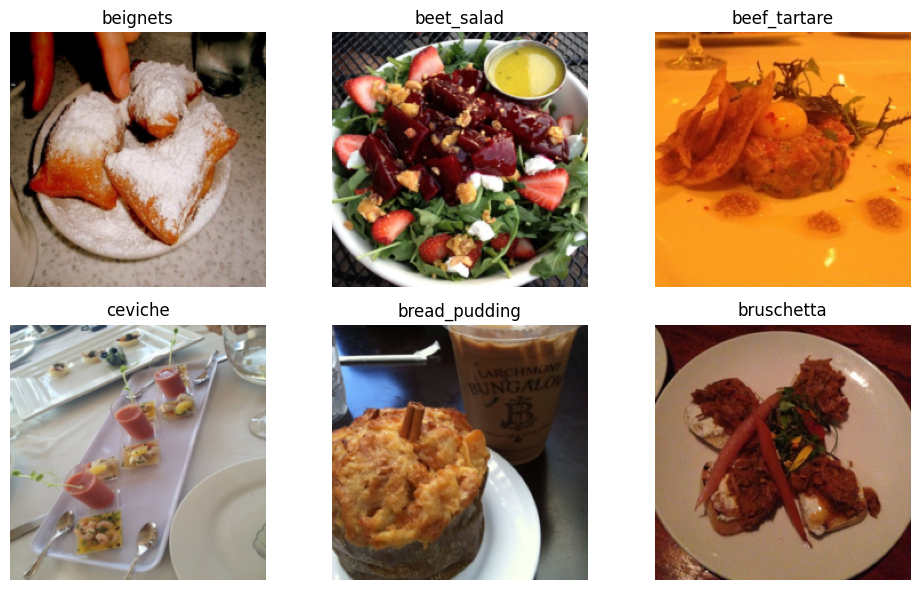

In [37]:
plt.figure(figsize=(10, 6))

for i in range(6):
    image, label = Xy_train[i]

    ax = plt.subplot(2, 3, i + 1)
    
    # If image is a tensor, convert it to numpy and transpose for matplotlib
    if isinstance(image, torch.Tensor):
        img = denormalize(image).permute(1, 2, 0).numpy()

    plt.imshow(img)
    plt.title(CLASS_NAMES[label])
    plt.axis("off")

plt.tight_layout()
plt.show()

## Data-Augmentation

In [ ]:
# Optional define/implements data-augmentation

## Training
### Step 1: Only train the head of the network

In [41]:
# Load MobileNetV2 without the classifier head
base_model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)
base_model.classifier = nn.Identity()  # Remove the original classification layer

# Freeze base model parameters
for param in base_model.parameters():
    param.requires_grad = False

# Build the new model with a custom head
class TransferModel(nn.Module):
    def __init__(self, base, num_classes):
        super().__init__()
        self.base = base
        self.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(1280, num_classes)
        )

    def forward(self, x):
        x = self.base(x)
        return self.classifier(x)

# Instantiate the full model
model = TransferModel(base_model, N_CLASSES)

# Print model summary
print(model)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /Users/jaron/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 26.4MB/s]

TransferModel(
  (base): MobileNetV2(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, kernel_size=(1,

In [46]:
def trainer(model, train_loader, val_loader, optimizer, criterion, n_epochs):
    history = {'train_loss': [], 'val_loss': []}

    for epoch in range(n_epochs):
        model.train()
        train_loss = 0
        for inputs, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{n_epochs}"):
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for inputs, targets in tqdm(val_loader, desc="Validation"):
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()

        train_loss /= len(train_loader)
        val_loss /= len(val_loader)

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)

        print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")
    
    return history

In [ ]:
lr = 1e-3
n_epochs = 10
batch_size = 64

train_loader = DataLoader(Xy_train, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(Xy_val, batch_size=batch_size, shuffle=False)

model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

history = trainer(model, train_loader, val_loader, optimizer, criterion, n_epochs)

Validation: 100%|██████████| 47/47 [00:16<00:00,  2.83it/s]


Epoch 1: Train Loss = 1.8407, Val Loss = 1.2970


Validation: 100%|██████████| 47/47 [00:15<00:00,  3.10it/s]


Epoch 2: Train Loss = 1.2498, Val Loss = 1.1689


Validation: 100%|██████████| 47/47 [00:22<00:00,  2.13it/s]


Epoch 3: Train Loss = 1.1429, Val Loss = 1.1172


Validation: 100%|██████████| 47/47 [00:18<00:00,  2.60it/s]


Epoch 4: Train Loss = 1.0909, Val Loss = 1.0743


Validation: 100%|██████████| 47/47 [00:16<00:00,  2.84it/s]


Epoch 5: Train Loss = 1.0454, Val Loss = 1.0678


Validation: 100%|██████████| 47/47 [00:16<00:00,  2.83it/s]


Epoch 6: Train Loss = 1.0314, Val Loss = 1.0659


Validation: 100%|██████████| 47/47 [00:16<00:00,  2.79it/s]


Epoch 7: Train Loss = 0.9969, Val Loss = 1.0658


Validation: 100%|██████████| 47/47 [00:17<00:00,  2.76it/s]


Epoch 8: Train Loss = 0.9926, Val Loss = 1.0630


Validation: 100%|██████████| 47/47 [00:18<00:00,  2.53it/s]


Epoch 9: Train Loss = 0.9849, Val Loss = 1.0563


Validation: 100%|██████████| 47/47 [00:16<00:00,  2.82it/s]

Epoch 10: Train Loss = 0.9613, Val Loss = 1.0666


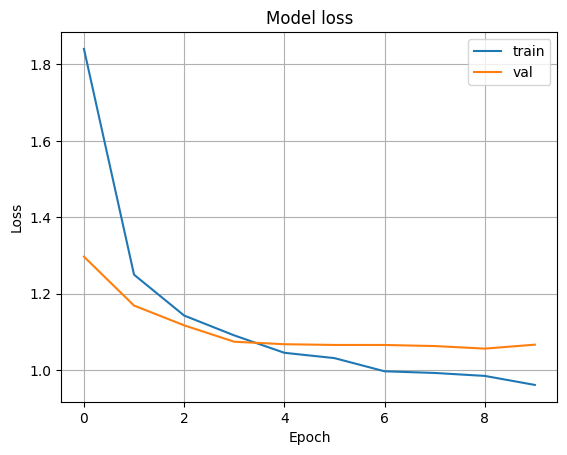

In [45]:
def plot_history(history, metric='loss'):
    plt.plot(history[f'train_{metric}'], label='train')
    plt.plot(history[f'val_{metric}'], label='val')
    plt.title(f'Model {metric}')
    plt.xlabel('Epoch')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.grid(True)
    plt.show()

plot_history(history, 'loss')

### Step 2: Fine-Tune the whole model

In [47]:
# Unfreeze the pretrained base
for param in model.base.parameters():
    param.requires_grad = True

# Compile and retrain the model
n_epochs = 5

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
step2_history = trainer(model, train_loader, val_loader, optimizer, criterion, n_epochs)

Validation: 100%|██████████| 47/47 [00:19<00:00,  2.47it/s]


Epoch 1: Train Loss = 0.8623, Val Loss = 0.9325


Validation: 100%|██████████| 47/47 [00:17<00:00,  2.75it/s]


Epoch 2: Train Loss = 0.7314, Val Loss = 0.8915


Validation: 100%|██████████| 47/47 [00:17<00:00,  2.71it/s]


Epoch 3: Train Loss = 0.6466, Val Loss = 0.8615


Validation: 100%|██████████| 47/47 [00:17<00:00,  2.75it/s]


Epoch 4: Train Loss = 0.5757, Val Loss = 0.8441


Validation: 100%|██████████| 47/47 [00:18<00:00,  2.59it/s]

Epoch 5: Train Loss = 0.5190, Val Loss = 0.8287


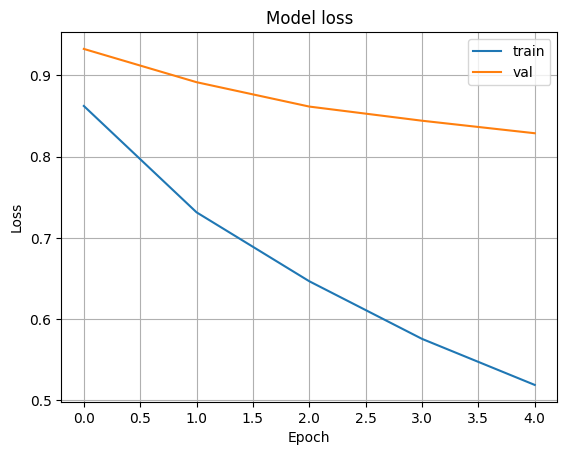

In [48]:
plot_history(step2_history, 'loss')

## Test the fine-tuned model

In [51]:
test_loader = DataLoader(Xy_test, batch_size=64, shuffle=False)

y_pred = []
y_true = []

model.eval()
with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Predicting"):
        inputs = inputs.to(device)
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1)

        y_pred.extend(preds.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))

Predicting: 100%|██████████| 79/79 [00:24<00:00,  3.21it/s]

                    precision    recall  f1-score   support

         apple_pie       0.61      0.64      0.62       250
    baby_back_ribs       0.87      0.86      0.87       250
           baklava       0.78      0.80      0.79       250
    beef_carpaccio       0.80      0.78      0.79       250
      beef_tartare       0.81      0.76      0.79       250
        beet_salad       0.69      0.69      0.69       250
          beignets       0.87      0.91      0.89       250
          bibimbap       0.88      0.92      0.90       250
     bread_pudding       0.68      0.61      0.64       250
 breakfast_burrito       0.80      0.72      0.76       250
        bruschetta       0.72      0.71      0.72       250
      caesar_salad       0.85      0.86      0.85       250
           cannoli       0.76      0.79      0.78       250
     caprese_salad       0.74      0.77      0.75       250
       carrot_cake       0.77      0.84      0.80       250
           ceviche       0.78      0.71

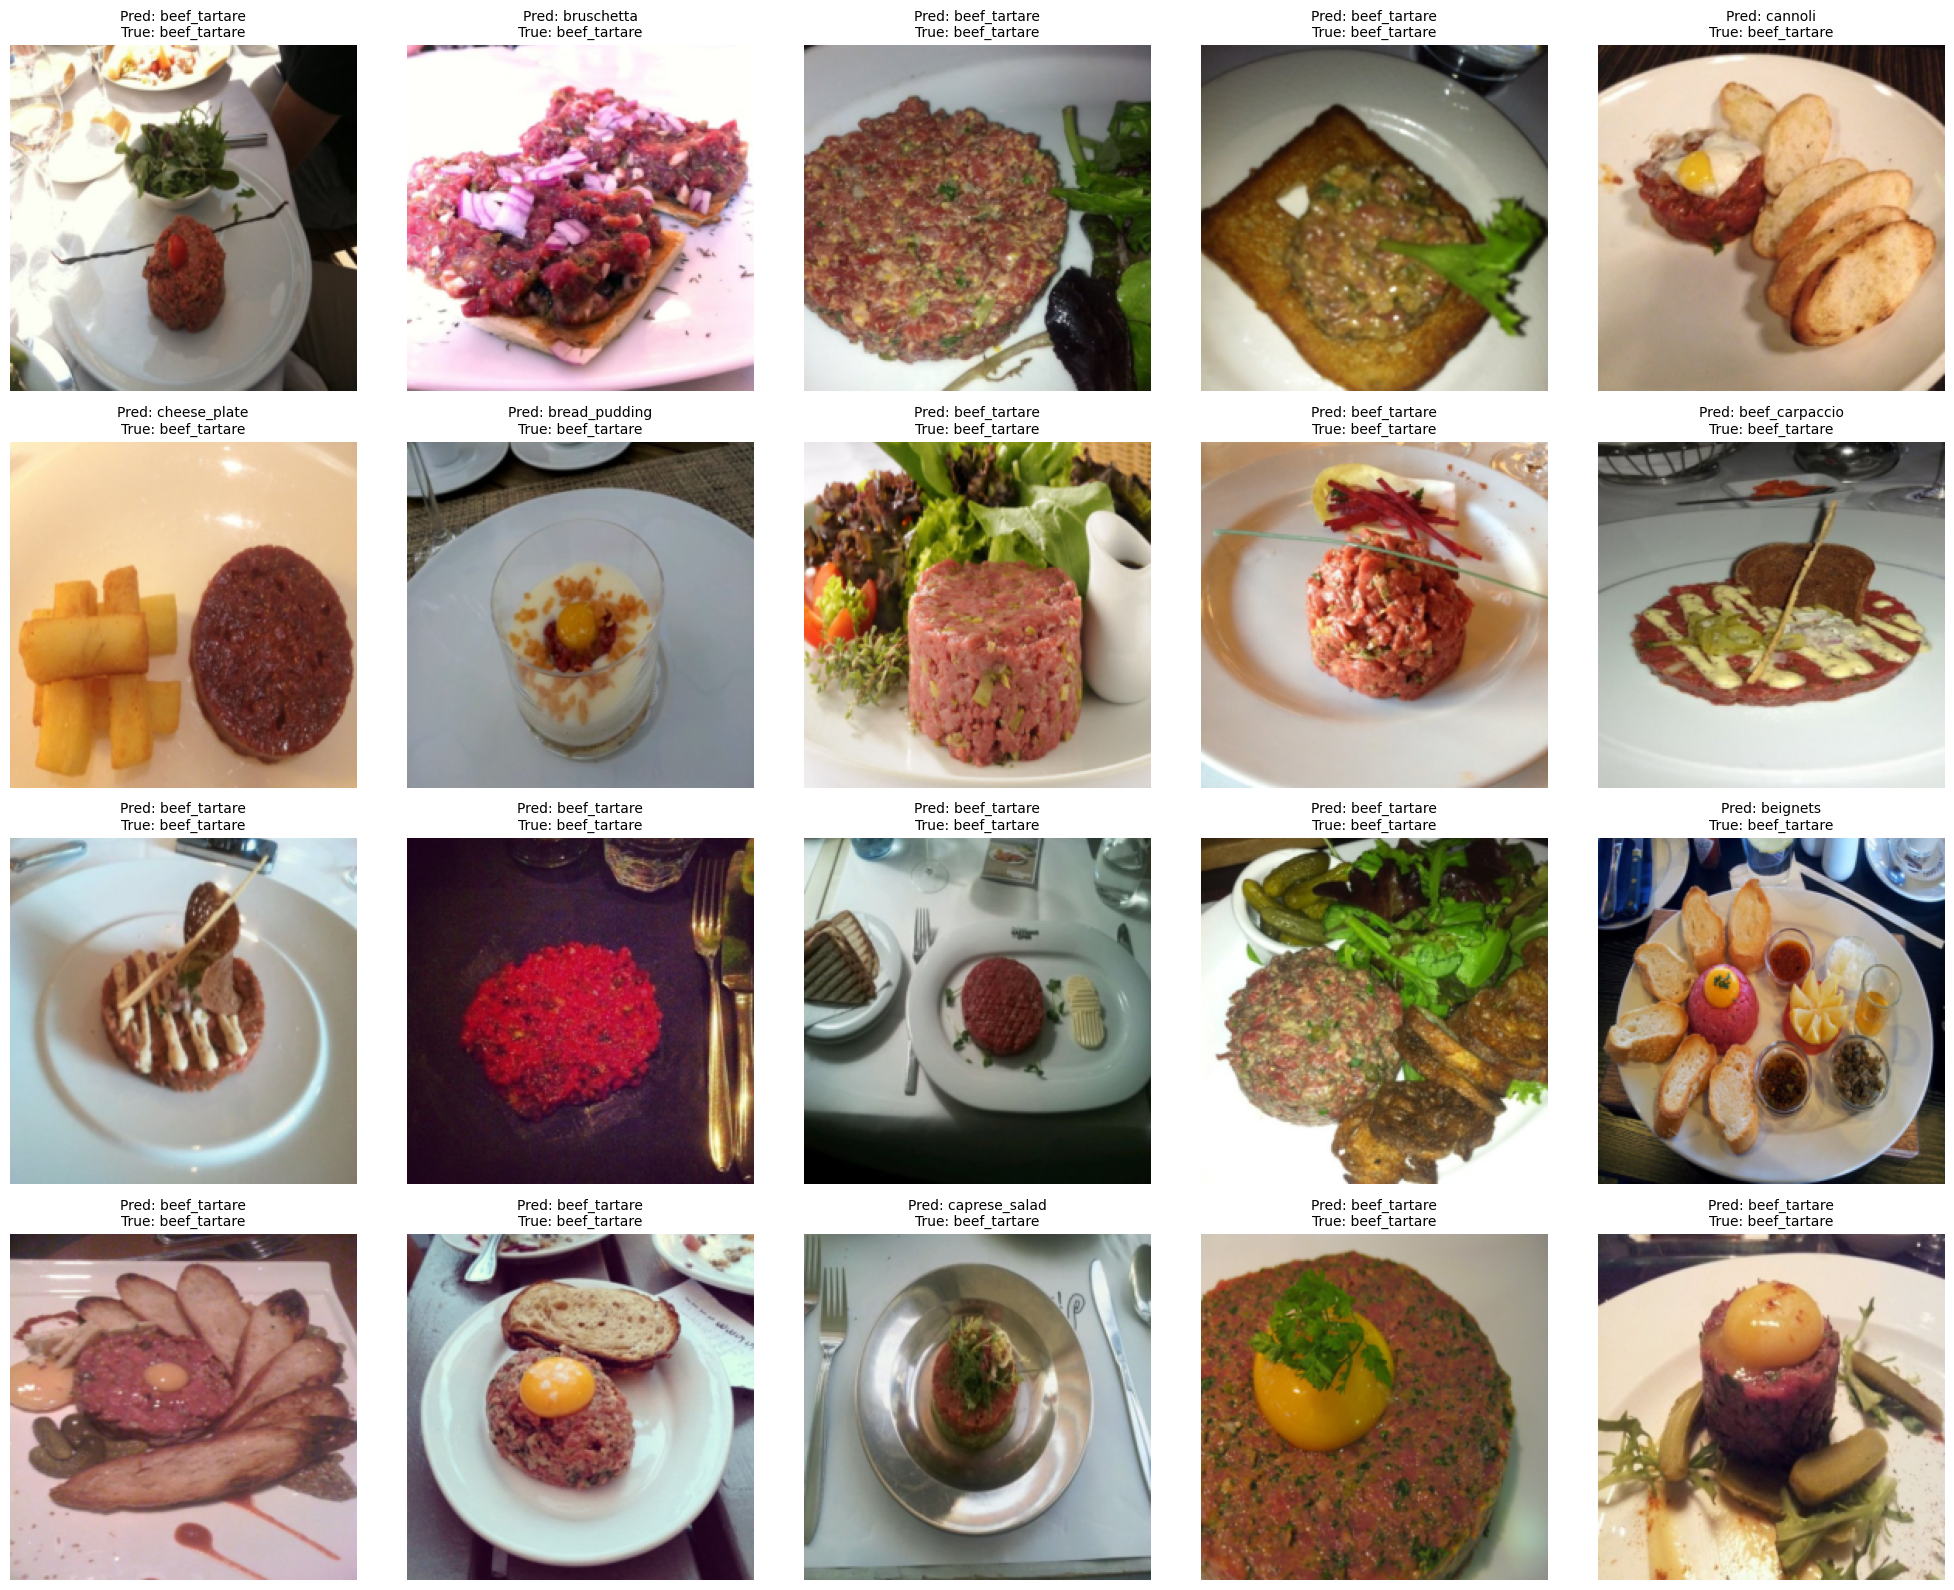

In [52]:
def show_images_prediction(dataset, y_pred, y_true, class_names, page=0, page_size=20):
    nrows = 4
    ncols = 5
    start_i = page * page_size

    _, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 16))

    for i, ax in enumerate(axes.flat):
        idx = start_i + i

        # Load the image and label from the dataset
        image_tensor, _ = dataset[idx]

        # Undo normalization (assuming ImageNet stats)
        mean = torch.tensor(MEAN)
        std = torch.tensor(STD)
        image_tensor = image_tensor * std[:, None, None] + mean[:, None, None]

        # Convert to numpy (C, H, W) -> (H, W, C)
        image_np = image_tensor.permute(1, 2, 0).numpy()
        image_np = np.clip(image_np, 0, 1)  # Keep values in [0, 1] range for display

        ax.imshow(image_np)
        ax.set_axis_off()

        pred_label = class_names[y_pred[idx]]
        true_label = class_names[y_true[idx]]
        ax.set_title(f"Pred: {pred_label}\nTrue: {true_label}", fontsize=10)

    plt.tight_layout()
    plt.show()

show_images_prediction(Xy_test, y_pred, y_true, CLASS_NAMES, page=2)